In [1]:
from pathlib import Path
import os

# Detectamos la ruta donde está guardado este notebook
notebook_dir = Path().resolve()
print(f"Directorio actual del notebook:\n{notebook_dir}\n")

# Cambiamos el directorio de trabajo a esta misma ruta
os.chdir(notebook_dir)

# Confirmamos
print(f"Nuevo directorio de trabajo:\n{os.getcwd()}")


Directorio actual del notebook:
C:\Users\USUARIO\Documents\TP3

Nuevo directorio de trabajo:
C:\Users\USUARIO\Documents\TP3


In [2]:
# === Librerías ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

# Configuración general
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set(style="whitegrid", palette="deep")

In [3]:
# === Cargar base del TP2 ===

import pandas as pd

eph = pd.read_csv("eph_base.csv")

print("Base cargada correctamente.")
print("Filas y columnas:", eph.shape)
display(eph.head(3))


Base cargada correctamente.
Filas y columnas: (7340, 37)


,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot
0,1.00,2005,125814,1,Varón,46,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,NaN,"2,400.00",480.00,Sí,...un sólo empleo/ocupación/actividad?,"2,400.00","2,400.00",No,46 a 60 años,1.00,3.93,805.93,0,2116,2,4,2,2.00,10.00,"2,518,778.11","845,811.04",48.00,0.00,1,48.00,5.00
1,2.00,2005,125814,1,Mujer,32,Casado,Obra social (incluye PAMI),Secundaria Incompleta,Inactivo,NaN,Ama de casa,"2,400.00",480.00,NaN,NaN,0.00,0.00,NaN,30 a 45 años,0.77,3.93,805.93,0,1024,2,4,2,2.00,10.00,"2,518,778.11","845,811.04",0.00,0.00,2,0.00,5.00
2,3.00,2005,125814,1,Varón,14,Soltero,Obra social (incluye PAMI),Primaria Completa,Inactivo,NaN,Estudiante,"2,400.00",480.00,NaN,NaN,0.00,0.00,NaN,14 años,0.96,3.93,805.93,0,196,1,3,2,7.00,8.00,"2,518,778.11","845,811.04",0.00,0.00,3,0.00,5.00


In [4]:
# Hay duplicados?
print("Duplicados:", eph.duplicated().sum())

# Hay valores faltantes?
print("\n Missings:\n", eph.isnull().sum()) # conteo
#print(auto.isnull().mean() * 100) # como porcentaje

# No hay duplicados ni missing values

Duplicados: 0

 Missings:
 componente              0
ano4                    0
codusu                  0
nro_hogar               0
Sexo                    0
ch06                    0
ch07                    0
ch08                   17
nivel_ed                0
estado                407
cat_ocup             4109
cat_inac             3278
itf                     0
ipcf                    0
pp07h                4796
pp03c                4526
p47t                    0
p21                     0
pp03g                4264
Edad                    0
adulto_equiv            0
ad_equiv_hogar          0
ingreso_necesario       0
pobre                   0
edad2                   0
ch10                    0
ch12                    0
ch13                    0
ch14                 3465
educ                  142
itf_2025                0
linea_pobreza           0
pp3e_tot             2333
pp3f_tot             2333
ch03                    0
horastrab              30
ix_tot                  0
dtype: int6

In [5]:
### Arreglamos un filtro adicional que encontramos que nos había faltado en la limpieza del TP1


#Estado
def clasificar_estado(estado, ch06):
    if pd.isna(estado) and ch06 < 10:
        return "Menor de 10 años"
    return estado

eph["estado"] = eph.apply(
    lambda row: clasificar_estado(row["estado"], row["ch06"]),
    axis=1)


#cat_ocup
def completar_cat_ocup(cat_ocup, estado):
    if pd.isna(cat_ocup):
        if estado in ["Inactivo", "Menor de 10 años", "Desocupado"]:
            return "No ocupado"
    return cat_ocup

eph["cat_ocup"] = eph.apply(
    lambda row: completar_cat_ocup(row["cat_ocup"], row["estado"]),
    axis=1
)



#Inactivo
def clasificar_estado(cat_inac, estado):
    if pd.isna(cat_inac) and estado == "Ocupado":
        return "Ocupado"
    if pd.isna(cat_inac) and estado == "Desocupado":
        return "Desocupado"
    return cat_inac

eph["cat_inac"] = eph.apply(
    lambda row: clasificar_estado(row["cat_inac"], row["estado"]),
    axis=1)


In [6]:

#dropeamos las filas con nan que son inconsistentes. son muy pocas observacions no afectan los resultados.

eph[["estado","ch08","educ","horastrab"]].isna().sum()

estado         1
ch08          17
educ         142
horastrab     30
dtype: int64

In [7]:
eph = eph.dropna(
    subset=["estado", "ch08", "educ","horastrab"]
)

In [8]:
# Hay valores faltantes?
print("\n Missings:\n", eph.isnull().sum()) # conteo

#Solo quedan nan variables numericas asocidas a personas con trabajo


 Missings:
 componente              0
ano4                    0
codusu                  0
nro_hogar               0
Sexo                    0
ch06                    0
ch07                    0
ch08                    0
nivel_ed                0
estado                  0
cat_ocup                0
cat_inac                0
itf                     0
ipcf                    0
pp07h                4642
pp03c                4389
p47t                    0
p21                     0
pp03g                4127
Edad                    0
adulto_equiv            0
ad_equiv_hogar          0
ingreso_necesario       0
pobre                   0
edad2                   0
ch10                    0
ch12                    0
ch13                    0
ch14                 3439
educ                    0
itf_2025                0
linea_pobreza           0
pp3e_tot             2304
pp3f_tot             2304
ch03                    0
horastrab               0
ix_tot                  0
dtype: int64


# A. Enfoque de validación

In [9]:
#Simplificamos variables categóricas con muchas categorías de manera innecesaria y categorías innecesarias para predicción y nos quedamos con las de interés

eph = eph[
    eph["ch08"] != "Ns./Nr."
]

eph = eph[
    eph["nivel_ed"] != "Ns./Nr."
]

eph = eph[
    eph["cat_inac"] != "Otros"
]


eph["ch10"] = eph["ch10"].astype("category")

eph["cobertura_medica"] = eph["ch08"].apply(
    lambda x: "no_tiene" if x == "No paga ni le descuentan" else "tiene"
)



cols = [
    "ano4",
    "componente",
    "codusu",
    "nro_hogar",
    "Sexo",        # corregido
    "ch06",
    "nivel_ed",
    "estado",
    "cat_ocup",    # corregido
    "cat_inac",    # interpretando tu pedido
    "pobre",
    "ch10",
    "cobertura_medica"
]

eph_variables_seleccionadas = eph[cols]


In [10]:
#Vemos cuales variables eran categóricas

# Variables e información
#print(auto.dtypes)
print(eph_variables_seleccionadas.info())


<class 'pandas.core.frame.DataFrame'>
Index: 7024 entries, 0 to 7339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ano4              7024 non-null   int64   
 1   componente        7024 non-null   float64 
 2   codusu            7024 non-null   object  
 3   nro_hogar         7024 non-null   int64   
 4   Sexo              7024 non-null   object  
 5   ch06              7024 non-null   int64   
 6   nivel_ed          7024 non-null   object  
 7   estado            7024 non-null   object  
 8   cat_ocup          7024 non-null   object  
 9   cat_inac          7024 non-null   object  
 10  pobre             7024 non-null   int64   
 11  ch10              7024 non-null   category
 12  cobertura_medica  7024 non-null   object  
dtypes: category(1), float64(1), int64(4), object(7)
memory usage: 720.4+ KB
None


In [11]:
#Creamos dummies para las variables categóricas:

eph_con_dummies = pd.get_dummies(
    eph_variables_seleccionadas.drop(columns=["codusu"]),
    drop_first=True,
    dtype=int
)

# Si querés volver a agregar codusu
eph_con_dummies["codusu"] = eph_variables_seleccionadas["codusu"]

eph_con_dummies.head()

,ano4,componente,nro_hogar,ch06,pobre,Sexo_Varón,nivel_ed_Primaria Incompleta (incluye educación especial),nivel_ed_Secundaria Completa,nivel_ed_Secundaria Incompleta,nivel_ed_Sin instrucción,nivel_ed_Superior Universitaria Completa,nivel_ed_Superior Universitaria Incompleta,estado_Inactivo,estado_Menor de 10 años,estado_Ocupado,cat_ocup_No ocupado,cat_ocup_Obrero o empleado,cat_ocup_Patrón,cat_ocup_Trabajador familiar sin remuneración,cat_inac_Desocupado,cat_inac_Discapacitado,cat_inac_Estudiante,cat_inac_Jubilado/pensionado,cat_inac_Menor de 6 años,cat_inac_Ocupado,cat_inac_Rentista,ch10_1,ch10_2,ch10_3,cobertura_medica_tiene,codusu
0,2005,1.00,1,46,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,125814
1,2005,2.00,1,32,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,125814
2,2005,3.00,1,14,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,125814
3,2005,4.00,1,9,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,125814
4,2005,5.00,1,3,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,125814


In [12]:
#Nos quedamos con las variables de interés para simplificar y evitar colinealidad

vars_seleccionadas = [
    "ch06",
    "Sexo_Varón",
    "nivel_ed_Primaria Incompleta (incluye educación especial)",
    "nivel_ed_Secundaria Completa",
    "nivel_ed_Secundaria Incompleta",
    "nivel_ed_Sin instrucción",
    "nivel_ed_Superior Universitaria Completa",
    "nivel_ed_Superior Universitaria Incompleta",
    "estado_Ocupado",
    "cobertura_medica_tiene",
    "pobre"
]

eph_con_dummies = eph_con_dummies[vars_seleccionadas]

In [13]:
# Guardo los vectores de variable dependiente y de variable independiente respectivamente:
y = eph_con_dummies['pobre']
X = eph_con_dummies.drop(columns=["pobre"])

# Agrego columna de 1s para el intercepto
X = sm.add_constant(X)

### 1. Test de medias

In [14]:
#Test de medias

resultados = []
for col in X.columns:
    x = X[col].values.reshape(-1, 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=444, stratify=y)
    t_x = stats.ttest_ind(x_train.flatten(), x_test.flatten())
    resultados.append({
        'Variable': col,
        'N train': x_train.shape[0],
        'Mean train': x_train.mean(),
        'sd train': x_train.std(),
        'N test': x_test.shape[0],
        'Mean test': x_test.mean(),
        'sd test': x_test.std(),
        't-test': t_x.statistic,
        'p-value': t_x.pvalue
    })

estadisticos = pd.DataFrame(resultados)
estadisticos.to_excel('dif_medias_multiple.xlsx', index=False)
estadisticos

C:\Users\USUARIO\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Variable,N train,Mean train,sd train,N test,Mean test,sd test,t-test,p-value
0,const,4916,1.00,0.00,2108,1.00,0.00,NaN,NaN
1,ch06,4916,34.75,21.52,2108,34.12,21.48,1.13,0.26
2,Sexo_Varón,4916,0.49,0.50,2108,0.48,0.50,1.31,0.19
3,nivel_ed_Primaria Incompleta (incluye educació...,4916,0.18,0.38,2108,0.17,0.38,0.44,0.66
4,nivel_ed_Secundaria Completa,4916,0.20,0.40,2108,0.21,0.41,-1.15,0.25
5,nivel_ed_Secundaria Incompleta,4916,0.22,0.41,2108,0.23,0.42,-0.48,0.63
6,nivel_ed_Sin instrucción,4916,0.06,0.24,2108,0.07,0.25,-1.39,0.16
7,nivel_ed_Superior Universitaria Completa,4916,0.11,0.31,2108,0.11,0.31,-0.02,0.99
8,nivel_ed_Superior Universitaria Incompleta,4916,0.10,0.30,2108,0.09,0.29,1.00,0.32
9,estado_Ocupado,4916,0.43,0.50,2108,0.42,0.49,1.06,0.29


### 2. Separación en respondieron_2005 y respondieron_2025

In [15]:
# Separar en dos dataframes según el año
respondieron_2005 = eph[eph['ano4'] == 2005].copy()
respondieron_2005.sample(3)

,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot,cobertura_medica
165,2.00,2005,159553,1,Mujer,43,Casado,Obra social (incluye PAMI),Primaria Completa,Ocupado,Obrero o empleado,Ocupado,845.00,105.62,No,...un sólo empleo/ocupación/actividad?,225.00,175.00,No,30 a 45 años,0.77,6.59,"1,351.41",1,1849,2,1,1,NaN,1.00,"886,819.79","1,418,293.84",40.00,0.00,2,40.00,8.00,tiene
3080,1.00,2005,270952,1,Mujer,30,Soltero,No paga ni le descuentan,Secundaria Incompleta,Ocupado,Obrero o empleado,Ocupado,"2,150.00",358.33,No,...un sólo empleo/ocupación/actividad?,850.00,700.00,No,30 a 45 años,0.77,4.18,857.19,0,900,2,4,2,3.00,11.00,"2,256,405.39","899,615.82",70.00,0.00,1,70.00,6.00,no_tiene
1576,3.00,2005,276281,1,Varón,26,Soltero,Mutual/Prepaga/Servicio de emergencia,Superior Universitaria Incompleta,Inactivo,No ocupado,Estudiante,300.00,100.00,NaN,NaN,0.00,0.00,NaN,18 a 29 años,1.02,2.54,520.88,1,676,1,7,2,5.00,18.00,"314,847.26","546,656.50",0.00,0.00,3,0.00,3.00,tiene


In [16]:
respondieron_2025 = eph[eph['ano4'] == 2025].copy()
respondieron_2025.sample(3)

,componente,ano4,codusu,nro_hogar,Sexo,ch06,ch07,ch08,nivel_ed,estado,cat_ocup,cat_inac,itf,ipcf,pp07h,pp03c,p47t,p21,pp03g,Edad,adulto_equiv,ad_equiv_hogar,ingreso_necesario,pobre,edad2,ch10,ch12,ch13,ch14,educ,itf_2025,linea_pobreza,pp3e_tot,pp3f_tot,ch03,horastrab,ix_tot,cobertura_medica
4262,1.00,2025,TQRMNOSXPHLOKSCDEOHCH00856169,1,Varón,72,Casado,Obra social (incluye PAMI),Secundaria Completa,Inactivo,No ocupado,Jubilado/pensionado,"1,520,000.00","253,333.33",NaN,NaN,"520,000.00",0.00,NaN,61 a 75 años,0.83,4.49,"1,639,644.73",1,5184,2,4,1,NaN,13.00,"1,520,000.00","1,639,644.73",NaN,NaN,1,0.00,6.00,tiene
6377,1.00,2025,TQRMNORPQHLMLMCDEOHCH00856185,1,Varón,40,Unido,Obra social (incluye PAMI),Secundaria Completa,Ocupado,Obrero o empleado,Ocupado,"1,300,000.00","260,000.00",Sí,...un sólo empleo/ocupación/actividad?,"900,000.00","900,000.00",No,30 a 45 años,1.00,3.77,"1,376,717.29",1,1600,2,4,1,NaN,13.00,"1,300,000.00","1,376,717.29",32.00,0.00,1,32.00,5.00,tiene
3758,1.00,2025,TQRMNORPTHJLKOCDEHGHJ00876480,1,Varón,43,Soltero,Obra social (incluye PAMI),Secundaria Incompleta,Ocupado,Obrero o empleado,Ocupado,"1,300,000.00","433,333.33",Sí,...un sólo empleo/ocupación/actividad?,"1,300,000.00","1,300,000.00",No,30 a 45 años,1.00,2.53,"923,897.81",0,1849,2,4,2,4.00,12.00,"1,300,000.00","923,897.81",40.00,0.00,1,40.00,3.00,tiene


# B. Modelo de Regresion Logística

### Armar X_2025, y_2025 y el train/test de respondieron_2025

In [17]:
# === B. Modelo de Regresión Logística – Preparación de datos (2025) ===

# Índices de quienes respondieron en 2025
idx_2025 = respondieron_2025.index

# Matriz de predictores: todas las columnas de eph_con_dummies salvo 'pobre'
X_2025 = eph_con_dummies.loc[idx_2025].drop(columns=["pobre"]).copy()

# Variable dependiente: pobreza (0/1)
y_2025 = eph_con_dummies.loc[idx_2025, "pobre"].copy()

print("Dimensión X_2025:", X_2025.shape)
print("Dimensión y_2025:", y_2025.shape)

# Train–test split estratificado (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_2025,
    y_2025,
    test_size=0.3,
    random_state=444,
    stratify=y_2025
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Proporción de pobres en train:", y_train.mean())
print("Proporción de pobres en test:", y_test.mean())


Dimensión X_2025: (4017, 10)
Dimensión y_2025: (4017,)
Tamaño X_train: (2811, 10)
Tamaño X_test: (1206, 10)
Proporción de pobres en train: 0.1992173603699751
Proporción de pobres en test: 0.19900497512437812


### Estimar el modelo Logit y construir la tabla (coef, error estándar, odds-ratio)

In [18]:
# === B.1 Estimación de la regresión logística (Logit) ===

# Agregamos constante solo para el Logit
X_train_logit = sm.add_constant(X_train, prepend=True)
X_test_logit = sm.add_constant(X_test, prepend=True)

logit_model = sm.Logit(y_train, X_train_logit)
logit_results = logit_model.fit()

# Resumen estándar en pantalla
print(logit_results.summary())


Optimization terminated successfully.
         Current function value: 0.423909
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  pobre   No. Observations:                 2811
Model:                          Logit   Df Residuals:                     2800
Method:                           MLE   Df Model:                           10
Date:                Sat, 15 Nov 2025   Pseudo R-squ.:                  0.1510
Time:                        04:04:47   Log-Likelihood:                -1191.6
converged:                       True   LL-Null:                       -1403.6
Covariance Type:            nonrobust   LLR p-value:                 7.535e-85
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const         

In [19]:
# === B.2 Tabla con coeficientes, errores estándar y odds-ratios ===

params = logit_results.params         # coeficientes
bse = logit_results.bse               # errores estándar
odds_ratios = np.exp(params)          # odds-ratios

tabla_logit = pd.DataFrame({
    "coeficiente": params,
    "error_estandar": bse,
    "odds_ratio": odds_ratios
})

tabla_logit


,coeficiente,error_estandar,odds_ratio
const,0.60,0.25,1.82
ch06,-0.01,0.00,0.99
Sexo_Varón,-0.10,0.11,0.91
nivel_ed_Primaria Incompleta (incluye educación especial),0.08,0.23,1.08
nivel_ed_Secundaria Completa,-0.21,0.20,0.81
nivel_ed_Secundaria Incompleta,0.14,0.21,1.15
nivel_ed_Sin instrucción,0.10,0.29,1.11
nivel_ed_Superior Universitaria Completa,-1.92,0.40,0.15
nivel_ed_Superior Universitaria Incompleta,-0.40,0.24,0.67
estado_Ocupado,-0.70,0.13,0.49


In [21]:
tabla_logit.to_excel("resultados_logit_respondieron_2025.xlsx", index=True)


### Efectos marginales

In [22]:
# === B.3 Efectos marginales promedio (AME) ===

marg_eff = logit_results.get_margeff(at="mean")
tabla_marginales = marg_eff.summary_frame()

tabla_marginales


,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
ch06,-0.00,0.00,-3.86,0.00,-0.00,-0.00
Sexo_Varón,-0.01,0.01,-0.91,0.36,-0.04,0.01
nivel_ed_Primaria Incompleta (incluye educación especial),0.01,0.03,0.34,0.73,-0.05,0.07
nivel_ed_Secundaria Completa,-0.03,0.03,-1.02,0.31,-0.08,0.02
nivel_ed_Secundaria Incompleta,0.02,0.03,0.67,0.50,-0.03,0.07
nivel_ed_Sin instrucción,0.01,0.04,0.36,0.72,-0.06,0.09
nivel_ed_Superior Universitaria Completa,-0.25,0.05,-5.35,0.00,-0.34,-0.16
nivel_ed_Superior Universitaria Incompleta,-0.05,0.03,-1.67,0.09,-0.11,0.01
estado_Ocupado,-0.09,0.02,-5.51,0.00,-0.12,-0.06
cobertura_medica_tiene,-0.19,0.02,-12.03,0.00,-0.22,-0.16


In [23]:
tabla_marginales.to_excel("efectos_marginales_logit_2025.xlsx")

### Visualización: probabilidad predicha vs. una variable numérica

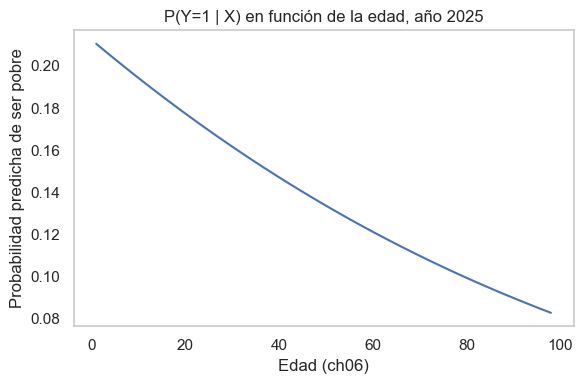

In [25]:
# === B.4 Visualización: P(Y=1|X) en función de ch06 (edad) – versión corregida ===

import numpy as np
import matplotlib.pyplot as plt

# Rango de valores de edad en la muestra de entrenamiento
min_edad = X_train["ch06"].min()
max_edad = X_train["ch06"].max()

grid_edad = np.linspace(min_edad, max_edad, 50)

# Partimos de la media de X_train_logit (incluye la constante y todas las covariables)
X_base = X_train_logit.mean()

# Construimos una matriz con tantas filas como puntos en el grid
X_plot_logit = pd.DataFrame(
    [X_base.values] * len(grid_edad),
    columns=X_train_logit.columns
)

# Sustituimos la columna de edad por el grid
X_plot_logit["ch06"] = grid_edad

# Predicción de probabilidades
p_hat = logit_results.predict(X_plot_logit)

# Gráfico
plt.figure(figsize=(6, 4))
plt.plot(grid_edad, p_hat)
plt.xlabel("Edad (ch06)")
plt.ylabel("Probabilidad predicha de ser pobre")
plt.title("P(Y=1 | X) en función de la edad, año 2025")
plt.tight_layout()
plt.grid(False)
plt.show()


# C. Método de Vecinos Cercanos (KNN)

### Entrenar KNN para K=1,5,10

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ks = [1, 5, 10]
resultados_knn = {}

for k in ks:

    # estandarizar + KNN
    modelo_knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    modelo_knn.fit(X_train, y_train)

    y_pred = modelo_knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    resultados_knn[k] = acc

    print(f"\n=== KNN con K = {k} ===")
    print("Accuracy:", acc)
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
    print("\nReporte clasificación:\n", classification_report(y_test, y_pred))


=== KNN con K = 1 ===
Accuracy: 0.7155887230514096
Matriz de confusión:
 [[775 191]
 [152  88]]

Reporte clasificación:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82       966
           1       0.32      0.37      0.34       240

    accuracy                           0.72      1206
   macro avg       0.58      0.58      0.58      1206
weighted avg       0.73      0.72      0.72      1206


=== KNN con K = 5 ===
Accuracy: 0.7744610281923715
Matriz de confusión:
 [[874  92]
 [180  60]]

Reporte clasificación:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87       966
           1       0.39      0.25      0.31       240

    accuracy                           0.77      1206
   macro avg       0.61      0.58      0.59      1206
weighted avg       0.74      0.77      0.75      1206


=== KNN con K = 10 ===
Accuracy: 0.8059701492537313
Matriz de confusión:
 [[933  33]
 [201  39]]

Rep

### Visualización de fronteras de decisión (K = 1 y K = 10)

Variables usadas para la frontera de decisión: ch06 y Sexo_Varón


C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


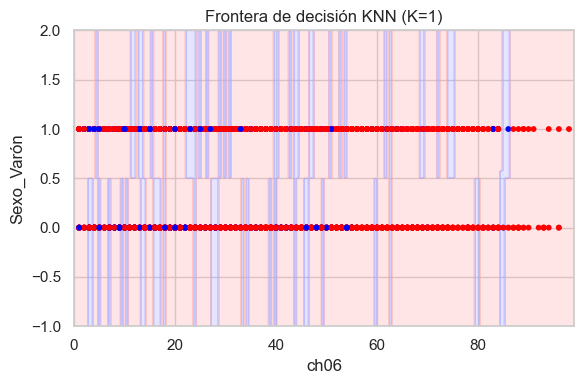

C:\Users\USUARIO\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


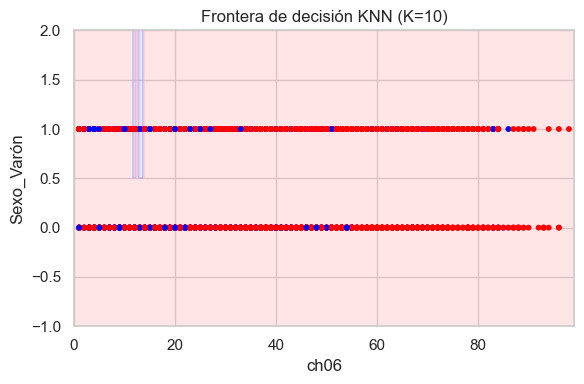

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Seleccionamos las primeras dos variables numéricas
vars_num = X_train.select_dtypes(include=[np.number]).columns[:2]
v1, v2 = vars_num[0], vars_num[1]

print("Variables usadas para la frontera de decisión:", v1, "y", v2)

def plot_knn_frontier(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[[v1, v2]], y_train)

    # Malla para frontera
    x_min, x_max = X_train[v1].min()-1, X_train[v1].max()+1
    y_min, y_max = X_train[v2].min()-1, X_train[v2].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 4))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA','#AAAAFF']))
    plt.scatter(X_train[v1], X_train[v2], c=y_train, cmap=ListedColormap(['#FF0000','#0000FF']), s=10)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.title(f"Frontera de decisión KNN (K={k})")
    plt.tight_layout()
    plt.show()

# Gráficos requeridos
plot_knn_frontier(1)
plot_knn_frontier(10)


### Selección de K óptimo con 5-fold Cross-Validation

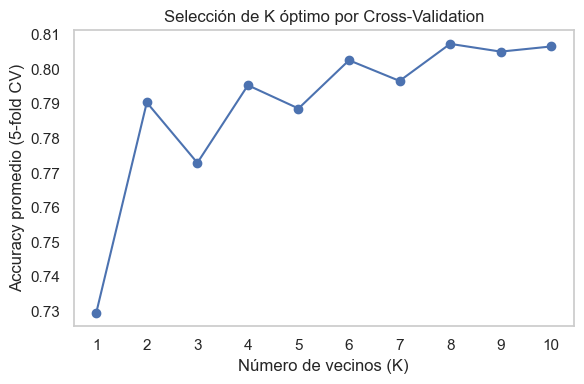

K óptimo según CV: 8


In [43]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Rango de vecinos a evaluar
ks = range(1, 11)
accuracy_cv = []

# Validación cruzada a 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=444)

for k in ks:
        modelo_knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    
    # >>> Usamos X_2025 y y_2025 para elegir K óptimo <<<
    scores = cross_val_score(
        modelo_knn,
        X_2025, y_2025,
        cv=kf,
        scoring='accuracy'
    )
    
    accuracy_cv.append(scores.mean())

# --- Gráfico ---
plt.figure(figsize=(6,4))
plt.plot(ks, accuracy_cv, marker='o')
plt.xlabel("Número de vecinos (K)")
plt.ylabel("Accuracy promedio (5-fold CV)")
plt.title("Selección de K óptimo por Cross-Validation")
plt.xticks(ks)
plt.grid(False)
plt.tight_layout()
plt.show()

# --- K óptimo ---
k_optimo = ks[np.argmax(accuracy_cv)]
print("K óptimo según CV:", k_optimo)


## Desempeño de modelos afuera de la muestra, métricas y políticas públicas

### Matriz de confusión del Logit (umbral p > 0.5)

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import numpy as np
import pandas as pd

# 1) Predicciones de probabilidad con el modelo Logit
y_pred_prob_logit = logit_results.predict(X_test_logit)

# Umbral de clasificación
umbral = 0.5
y_pred_logit = (y_pred_prob_logit > umbral).astype(int)

# Matriz de confusión para Logit
cm_logit = confusion_matrix(y_test, y_pred_logit)

print("=== Matriz de confusión – Logit (umbral 0.5) ===")
print(cm_logit)


=== Matriz de confusión – Logit (umbral 0.5) ===
[[928  38]
 [188  52]]


### K óptimo por CV, modelo KNN final y curvas ROC de ambos modelos en un solo gráfico

K óptimo según CV: 8

=== Matriz de confusión – KNN (K óptimo, umbral 0.5) ===
[[929  37]
 [201  39]]


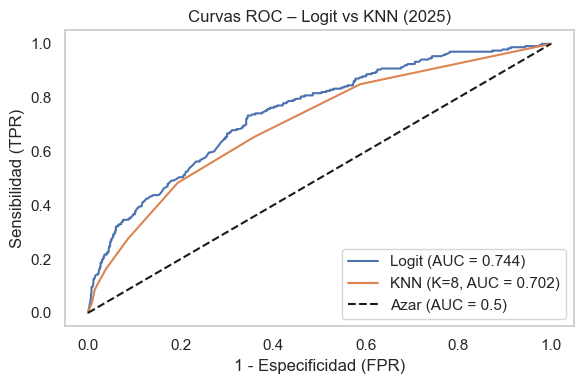

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 2.1) Selección de K óptimo por Cross-Validation (con escalado)
ks = range(1, 11)
accuracy_cv = []
kf = KFold(n_splits=5, shuffle=True, random_state=444)

for k in ks:
    knn_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    scores = cross_val_score(knn_pipe, X_2025, y_2025, cv=kf, scoring="accuracy")
    accuracy_cv.append(scores.mean())

k_optimo = ks[np.argmax(accuracy_cv)]
print("K óptimo según CV:", k_optimo)

# 2.2) Entrenamos el KNN óptimo en el set de entrenamiento
modelo_knn_opt = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=k_optimo))
])
modelo_knn_opt.fit(X_train, y_train)

# Probabilidades predichas de pobreza (clase 1) en el test
y_pred_prob_knn = modelo_knn_opt.predict_proba(X_test)[:, 1]

# Para comparación, también matriz de confusión de KNN con umbral 0.5
y_pred_knn = (y_pred_prob_knn > 0.5).astype(int)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print("\n=== Matriz de confusión – KNN (K óptimo, umbral 0.5) ===")
print(cm_knn)

# 2.3) Curvas ROC para ambos modelos

# ROC Logit
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_prob_logit)
auc_logit = roc_auc_score(y_test, y_pred_prob_logit)

# ROC KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

plt.figure(figsize=(6, 4))
plt.plot(fpr_logit, tpr_logit, label=f"Logit (AUC = {auc_logit:.3f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (K={k_optimo}, AUC = {auc_knn:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Azar (AUC = 0.5)")
plt.xlabel("1 - Especificidad (FPR)")
plt.ylabel("Sensibilidad (TPR)")
plt.title("Curvas ROC – Logit vs KNN (2025)")
plt.legend()
plt.grid(False) 
plt.tight_layout()
plt.show()


### Tabla con dos métricas de clasificación para ambos modelos

In [40]:
# 3) Tabla de métricas para Logit y KNN (K óptimo)

metricas_modelos = []

# Métricas para Logit
acc_logit = accuracy_score(y_test, y_pred_logit)
recall_logit = recall_score(y_test, y_pred_logit)  # asumiendo pobreza = 1

metricas_modelos.append({
    "Modelo": "Logit",
    "Accuracy": acc_logit,
    "Recall (pobre=1)": recall_logit
})

# Métricas para KNN
acc_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)

metricas_modelos.append({
    "Modelo": f"KNN (K={k_optimo})",
    "Accuracy": acc_knn,
    "Recall (pobre=1)": recall_knn
})

tabla_metricas = pd.DataFrame(metricas_modelos)
print("\n=== Métricas de desempeño en el test 2025 ===")
print(tabla_metricas)



=== Métricas de desempeño en el test 2025 ===
       Modelo  Accuracy  Recall (pobre=1)
0       Logit      0.81              0.22
1  KNN (K=10)      0.80              0.16
